In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

In [2]:
%load_ext pyinstrument

In [ ]:
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

tmp = pack_ga2.GA()

# runner = pack_ga2.Orchestrator(n_generations=3 if not fastMode else 50)
# runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
# runner.ga.diversity_reset_threshold = 5./40
# runner.ga.mate_distance=6

# ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
# #ga_base.population_size = 250
# #ga_base.prob_mate_own = 0.25
# value = 0.125
# ga_base.population_size = int(ga_base.population_size * value)
# ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
# seen = set()
# unique_selection = []
# for s in ga_base.selection_size:
#     while s in seen:
#         s += 1
#     seen.add(s)
#     unique_selection.append(s)
# ga_base.selection_size = unique_selection
# ga_base.selection_size = ga_base.selection_size[:-6]
# print(ga_base.selection_size)
# ga_base.do_legalize = False
# ga_base.reset_check_generations = 50 if not fastMode else 3
# ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
# ga_base.freeze_duration = 100 if not fastMode else 3
# #ga_base.move.moves[-1][2] *= 2
# ga_base.prob_mate_own = 0.7
# ga_base.reduce_h_threshold = 1e-5/40
# ga_base.always_allow_mate_with_better = False
# ga_base.fixed_h = -1.

# runner.ga.ga_base = ga_base
# runner.ga.do_legalize = False
# runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
# runner.ga.make_own_fig = (2,3)
# runner.ga.make_own_fig_size = (18,12)
# runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)) ,(1,True,(1,0)))
# runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,1)) ,(1,True,(1,1)))
# runner.ga.champion_phenotype_ax = (0,2)
# runner.ga.plot_diversity_ax = (1,2)
# runner.diagnostic_plot = False
# runner.seed = 0

runner_one_nTree = pack_ga2.baseline()
runner_one_nTree.ga.do_legalize = False
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
N_trees_list = [156]
for N_tree in N_trees_list:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
    ga_list[-1].ga_base.lap_config.algorithm = 'auction'
    ga_list[-1].ga_base.lap_config.auction_max_iters = 0
    ga_list[-1].ga_base.lap_config.auction_max_rounds = 3
    ga_list[-1].do_legalize= False
    ga_list[-1].N = 4
runner.ga = pack_ga2.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = False
runner.plot_every = 3
runner.n_generations = 1 if not fastMode else 3
runner.filename = 'matching_test'

runner.seed=84
runner.save_every = 1
runner.run() #warmup

import lap_batch

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0: Best costs = [[0.371981, 0.080582]]


In [4]:
runner = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')
runner.n_generations = 3

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 1: Best costs = [[0.371981, 0.036552]]
Generation 2: Best costs = [[0.371981, 0.026098]]


_     ._   __/__   _ _  _  _ _/_   Recorded: 22:19:37  Samples:  4134
 /_//_/// /_\ / //_// / //_'/ //     Duration: 6.327     CPU time: 6.491
/   _/                      v5.1.1

Cell [6]

7.108 <module>  /tmp/ipykernel_3355/3244083022.py:1
`- 7.107 Orchestrator.run  pack_ga3.py:1101
   |- 4.874 Orchestrator._relax  pack_ga3.py:1069
   |  `- 4.874 run_simulation_list  pack_dynamics.py:633
   |     `- 4.872 OptimizerBFGS.run_simulation  pack_dynamics.py:42
   |        `- 4.862 lbfgs  lbfgs_torch_parallel.py:382
   |           |- 2.867 f_torch  pack_dynamics.py:68
   |           |  |- 2.476 Device.synchronize  <built-in>
   |           |  |- 0.262 CostCompound.compute_cost  pack_cost.py:50
   |           |  |  `- 0.255 CostCompound._compute_cost  pack_cost.py:91
   |           |  |     |- 0.140 BoundaryDistanceCost.compute_cost  pack_cost.py:50
   |           |  |     `- 0.115 [self]  pack_cost.py
   |           |  `- 0.091 [self]  pack_dynamics.py
   |           |- 1.593 [self]  lbfgs_torch_parallel.py
   |           `- 0.078 Tensor.any  <built-in>
   |- 1.156 GAMulti.apply_selection  pack_ga3.py:295
   |  `- 1.156 GAMulti._apply_selection  pack_ga3.py:474
   |     `- 1.156 GAMultiRing.apply_selection  pack_ga3.py:295
   |        `- 1.156 GAMultiRing._apply_selection  pack_ga3.py:474
   |           `- 1.156 GASinglePopulationOld.apply_selection  pack_ga3.py:295
   |              `- 1.156 GASinglePopulationOld._apply_selection  pack_ga3.py:905
   |                 |- 0.936 compute_genetic_diversity  kaggle_support.py:1074
   |                 |  `- 0.932 compute_genetic_diversity_matrix  kaggle_support.py:942
   |                 |     |- 0.641 [self]  kaggle_support.py
   |                 |     `- 0.244 solve_lap_batch  lap_batch.py:259
   |                 |        `- 0.226 Device.synchronize  <built-in>
   |                 `- 0.208 compute_genetic_diversity_matrix  kaggle_support.py:942
   |                    |- 0.098 solve_lap_batch  lap_batch.py:259
   |                    |  `- 0.098 Device.synchronize  <built-in>
   |                    `- 0.079 Device.synchronize  <built-in>
   |- 0.731 dill_save  kaggle_support.py:149
   |  `- 0.700 dump  dill/_dill.py:250
   |        [92 frames hidden]  dill, pickle, <built-in>
   `- 0.309 GAMulti.generate_offspring  pack_ga3.py:254
      `- 0.309 GAMulti._generate_offspring  pack_ga3.py:464
         `- 0.309 GAMultiRing.generate_offspring  pack_ga3.py:254
            `- 0.309 GAMultiRing._generate_offspring  pack_ga3.py:543
               `- 0.306 GASinglePopulationOld.generate_offspring  pack_ga3.py:254
                  `- 0.301 GASinglePopulationOld._generate_offspring  pack_ga3.py:943
                     `- 0.288 MoveSelector.do_move_vec  pack_move.py:42
                        `- 0.288 MoveSelector._do_move_vec  pack_move.py:83
                           `- 0.232 Crossover.do_move_vec  pack_move.py:42
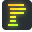

In [5]:
%%pyinstrument
kgs.profiling=True
#kgs.enable_module_profiling(kgs)
#kgs.enable_module_profiling(lap_batch)
runner.run()

In [6]:
kgs.print_module_profile()

In [7]:
print(runner.ga.ga_list[0].ga_list[1].lap_config)

LAPConfig(algorithm='auction', auction_epsilon_init=0.1, auction_epsilon_final=0.001, auction_epsilon_decay=0.8, auction_max_rounds=3, auction_max_iters=0)
